In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Load data 

In [8]:
# import acceleromter data
data = np.genfromtxt(r'data/300_steps_in_pocket-2021-00-11_11-24-20/Accelerometer.csv',delimiter=',',skip_header=1)
data = data[:,1:]

sample_rate = 10/1000 # rate in seconds

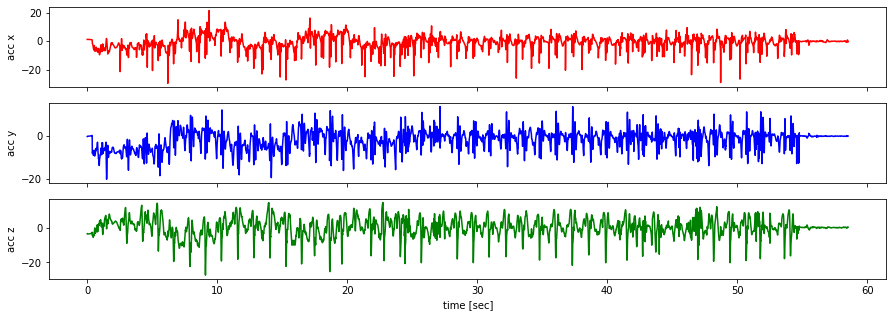

In [9]:
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(np.arange(len(data))*sample_rate,data[:,0],'-r')
axs[0].set_ylabel('acc x')

axs[1].plot(np.arange(len(data))*sample_rate,data[:,1],'-b')
axs[1].set_ylabel('acc y')

axs[2].plot(np.arange(len(data))*sample_rate,data[:,2],'-g')
axs[2].set_ylabel('acc z')

axs[2].set_xlabel('time [sec]')


plt.show()

## Preprocessing

In [10]:
# compute combined acceleromter magnitude
data = np.sqrt(data[:,0]**2 + data[:,1]**2 + data[:,2]**2)

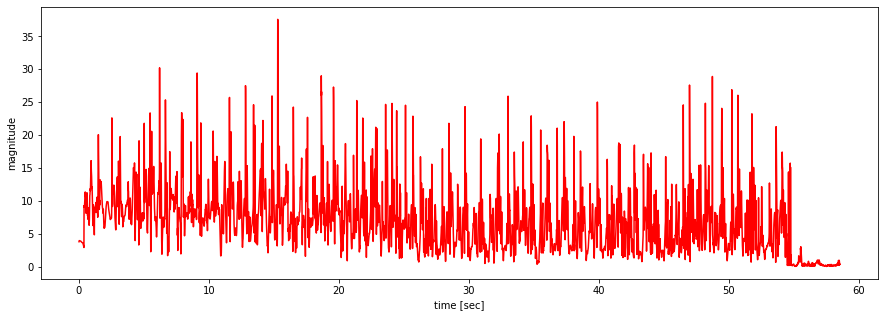

In [11]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(data))*sample_rate,data,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

## We will compare between basic threshold steps counter to the proposed rubustStepCounter

### Methods functions

In [ ]:
def thresholdStepCounter(data, sample_rate, peak_threshold, peaks_min_distance=0.5, N):
    
    peaks_min_distance_flag = True
    time_from_last_peak = peaks_min_distance+1 # we initialize it to be greater then min distance 
    steps_counter = 0
    peaks =[]

    for i, datum in enumerate(data):

        if datum > peak_threshold and peaks_min_distance_flag:
            steps_counter +=1
            peaks.append(i)
            time_from_last_peak = 0 
            
        time_from_last_peak += sample_rate
        peaks_min_distance_flag = time_from_last_peak >= peaks_min_distance
        
    steps = np.asarray(peaks[N-1:-1]) # first N peaks and the last peak are not counted (to compare with the robust )
    return steps

In [ ]:
def robusttepCounter(data, sample_rate, K, M, N, T_max, T_min, sim_threshold, var_threshold):
# peak detection
K = int(0.4/sample_rate) # min distance between peaks threshold [samples]
peaks = peak_detector(data,K)
# # plot result
# fig = plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(data))*sample_rate,data,'-r')
# plt.scatter(peaks*sample_rate,data[peaks])
# plt.ylabel('acceleration magnitude')
# plt.xlabel('time [sec]')
# plt.title(str(len(peaks)) + ' peaks detected')
# plt.show()
steps = []
steps_count = 0
for i in range(N-1,len(peaks)-1):
    C = calculate_continuity(i,data,peaks,M,N,var_threshold)
    # prints for debug
    print('continuity: ',C)
    print('similarity: ',calculate_similarity(data,i,peaks))
    print('periodicity: ',calculate_periodicity(i,peaks,sample_rate))
    #
    if C == 0:
        continue
    elif calculate_similarity(data,i,peaks)<=sim_threshold:
        continue
    elif T_min<calculate_periodicity(i,peaks,sample_rate)<T_max:
        steps_count +=1
        steps.append(peaks[i])

steps = np.asarray(steps)
return steps, peaks

Method parameters

In [ ]:
K = 15 # min distance between peaks [samples]
T_min = 0.3 # periodicity min [sec]
T_max = 1 # periodicity max [sec]
sim_threshold = -5 # similarity threshold
M = 2 # number threshold for continuity
N = 4 # window size for continuity
var_threshold = 0.7 # variance threshold for continuity